# Common Statistical Models

In [106]:
library(tidyverse)
library(rjags)
library(rstan)
library(boot)
library(bayesplot)
library(caret)

## 8. ANOVA

ANOVA compares the variability of responses **within groups** to the variability of responses **between groups**.

### Related Terms

Types|Independent Var.|Dependent Var.
---|-|-
**One-way ANOVA**|**one** factor | **one** continuous var.
**Two-way ANOVA**|**two** factors | **one** continuous var.
**ANCOVA**(Analysis of Covariance) | **several factors** and **several** continuous vars. (**=covariates**) | **one** continuous var.
**MANOVA**(Multivariate ANOVA) | **several factors**  | **several** continuous vars
**MANCOVA** | **several factors** and **several covariates** | **several** continuous vars

In [21]:
data("PlantGrowth")

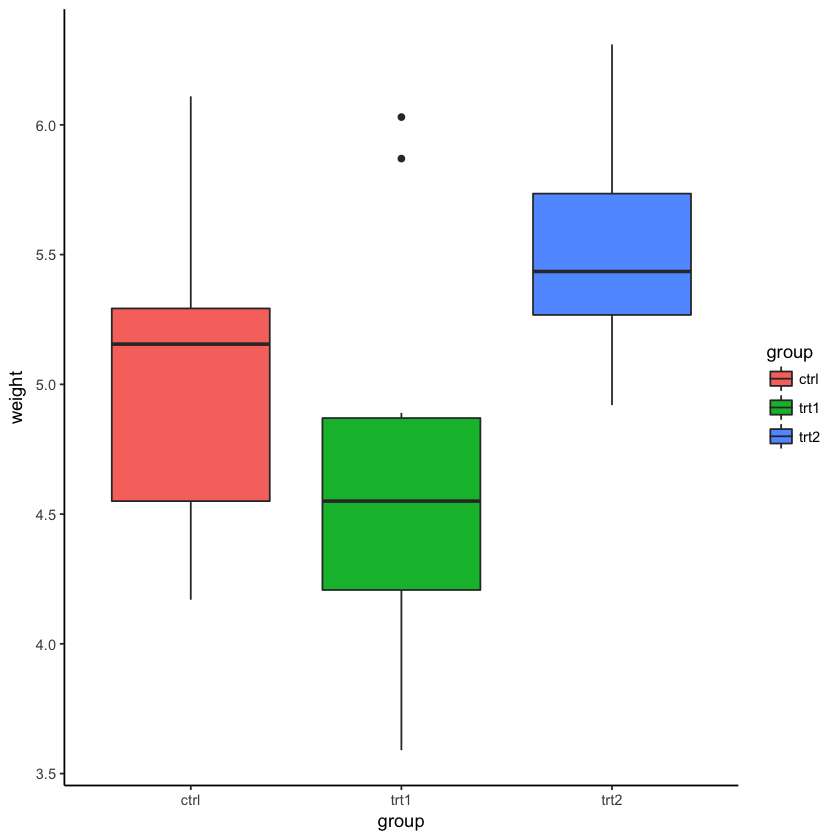

In [10]:
ggplot(PlantGrowth, aes(x=group, y=weight, fill=group)) + 
    geom_boxplot() +
    theme_classic()

### Frequentist Modeling

$$
y_i \mid g_i, \mu, \sigma^2 \overset{ind}{\sim} N(\mu_g, \sigma^2)
$$

In [15]:
lmod = lm(weight ~ group, data=PlantGrowth)
summary(lmod)


Call:
lm(formula = weight ~ group, data = PlantGrowth)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0710 -0.4180 -0.0060  0.2627  1.3690 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.0320     0.1971  25.527   <2e-16 ***
grouptrt1    -0.3710     0.2788  -1.331   0.1944    
grouptrt2     0.4940     0.2788   1.772   0.0877 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6234 on 27 degrees of freedom
Multiple R-squared:  0.2641,	Adjusted R-squared:  0.2096 
F-statistic: 4.846 on 2 and 27 DF,  p-value: 0.01591


In [20]:
glm(weight ~ group, data=PlantGrowth, family="gaussian"(link="identity"))


Call:  glm(formula = weight ~ group, family = gaussian(link = "identity"), 
    data = PlantGrowth)

Coefficients:
(Intercept)    grouptrt1    grouptrt2  
      5.032       -0.371        0.494  

Degrees of Freedom: 29 Total (i.e. Null);  27 Residual
Null Deviance:	    14.26 
Residual Deviance: 10.49 	AIC: 61.62

### Bayesian Modeling (JAGS)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 30
   Unobserved stochastic nodes: 4
   Total graph size: 74

Initializing model



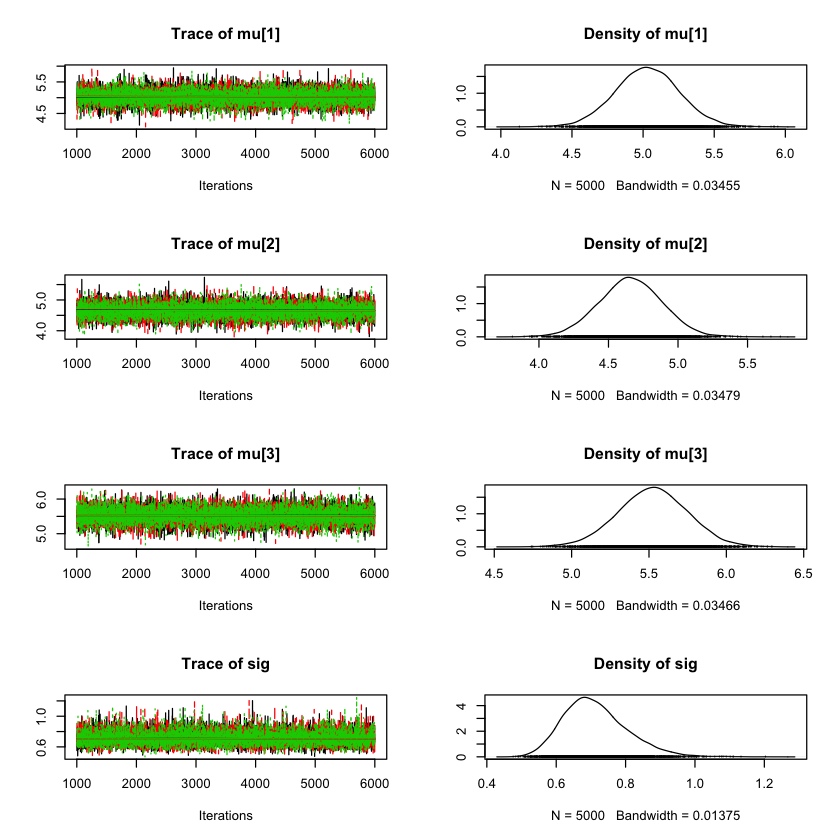

In [24]:
modString = " model {
    for (i in 1:length(y)) {
        y[i] ~ dnorm(mu[grp[i]], prec)
    }
    
    for (j in 1:3) {
        mu[j] ~ dnorm(0.0, 1.0/1.0e6)
    }
    
    prec ~ dgamma(5/2.0, 5*1.0/2.0)
    sig = sqrt( 1.0 / prec )
} "


dataJags = list(y=PlantGrowth$weight, 
                grp=as.numeric(PlantGrowth$group))

params = c("mu", "sig")

inits = function() {
    inits = list("mu"=rnorm(3,0.0,100.0), "prec"=rgamma(1,1.0,1.0))
}

mod = jags.model(textConnection(modString), data=dataJags, inits=inits, n.chains=3)
update(mod, 1e3)

mod_sim = coda.samples(model=mod,
                       variable.names=params,
                       n.iter=5e3)
mod_csim = as.mcmc(do.call(rbind, mod_sim))

plot(mod_sim)

### Model Checking

In [69]:
print("Gelman & Rubin Convergen Diagnostic : potential scale reduction factor")
gelman.diag(mod_sim)
print("Raftery & Lewis Diagnostic : dependence factor")
raftery.diag(mod_sim) # dependence factor I indicates the extent to which autocorrelation inflates required sample size
print("Autocorrelation")
autocorr.diag(mod_sim)
print("Effective Size")
effectiveSize(mod_sim)

[1] "Gelman & Rubin Convergen Diagnostic : potential scale reduction factor"


Potential scale reduction factors:

      Point est. Upper C.I.
mu[1]          1          1
mu[2]          1          1
mu[3]          1          1
sig            1          1

Multivariate psrf

1

[1] "Raftery & Lewis Diagnostic : dependence factor"


[[1]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
       Burn-in  Total Lower bound  Dependence
       (M)      (N)   (Nmin)       factor (I)
 mu[1] 2        3561  3746         0.951     
 mu[2] 2        3803  3746         1.020     
 mu[3] 2        3680  3746         0.982     
 sig   2        3995  3746         1.070     


[[2]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
       Burn-in  Total Lower bound  Dependence
       (M)      (N)   (Nmin)       factor (I)
 mu[1] 2        3741  3746         0.999     
 mu[2] 2        3741  3746         0.999     
 mu[3] 2        3930  3746         1.050     
 sig   2        3803  3746         1.020     


[[3]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
       Burn-in  Total Lower bound  Dependence
       (M)      (N)   (Nmin) 

[1] "Autocorrelation"


,mu[1],mu[2],mu[3],sig
Lag 0,1.000000000,1.000000000,1.000000000,1.000000000
Lag 1,0.003453973,-0.006234304,0.004190718,0.093126454
Lag 5,-0.020008960,-0.011557434,-0.002573788,0.015258149
Lag 10,-0.001728245,-0.009101280,-0.005012217,-0.016355884
Lag 50,0.005985316,0.010226255,0.001631703,-0.001744098


[1] "Effective Size"


mu[1]    mu[2]    mu[3]      sig 
14522.05 14565.29 14294.75 12445.82

#### Difference between the means of levels

In [26]:
mean(mod_csim[,3] > mod_csim[,1])
mean(mod_csim[,3] > 1.1*mod_csim[,1])

[1] 0.9419333

[1] 0.4906667

#### HPD for mean difference

"the effect of treatment 2 with respect to the control in mean plant weight, or $\beta_2$ **parameter**"

As we see here, posterior samples can be used to obtain **simulated posterior distributions** of any function of the parameters.

That is, posterior distributions provide a rich tool for characterizing our **uncertainty** and **updated beliefs** about parameters.

In [66]:
HPDinterval(mod_csim[,3] - mod_csim[,1])
mean(mod_csim[,3] > mod_csim[,1])

,lower,upper
var1,-0.1477337,1.110777


[1] 0.9419333

## More) Two-way ANOVA

### a) Additive Model (without interaction)

#### Linear model parameterization

If we have both **categorical** and **continuous** covariates, it is common to use **linear model parameterization** using **dummy vars**

+ e.g. 2 x 3 x 2 design using covariates **dose**(100mg, 200mg) x **freq**(daily, twice, once) x **physical activity**(low, high)



$$
\mathbb{E} (y_i) = \beta_0 + \beta_1 I_{dose_i=200} + \beta_2 I_{freq_i=twice} + \beta_3 I_{freq_i=once} 
+ \beta_4 I_{phys_i=high} + \beta_5 \text{weight}_i + \beta_6 \text{heart}_i
$$

### b) Full Cell Means Model

### Bayes Factor

Bayes factor is defined as **the ratio of the likelihood of two competing hypotheses** (usually, $H_0$, $H_1$)

It can be calculated by **numerical integration via MCMC**

$$
\begin{aligned}
BF_{i,j} &= \frac {  Likelihood(Y \mid M_i) }  {Likelihood(Y \mid M_j) } \\[10pt]
&=  \frac {   \int Likeihood(Y \mid M_i, \theta_i) p ( \theta_i \mid M_i) d \theta  } 
            {  \int Likeihood(Y \mid M_j, \theta_j) p( \theta_j \mid M_j) d \theta} 
\end{aligned}
$$

Bayesian alternative to **classical hypothesis testing** (c.f. HPD interval of mean difference)

+ used in Bayesian model comparison, to **quantify the support for a model over another**.

+ models in comparison **need not to be nested**

+ **transitive** model comparison

In [2]:
library(BayesFactor)

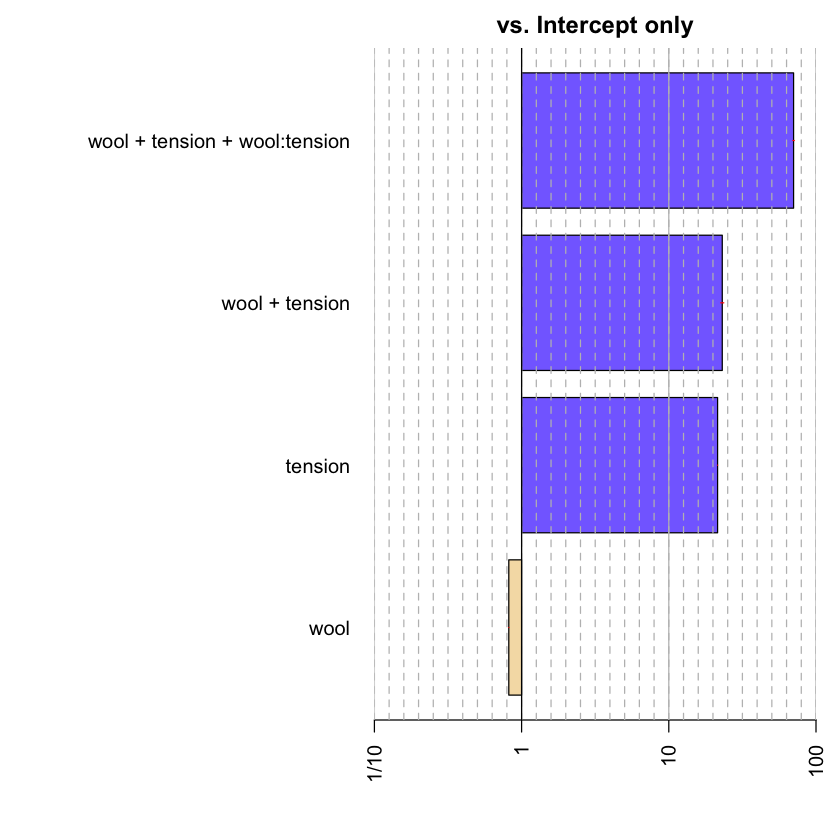

In [3]:
par(mfrow=c(1,1))
BFmodel = anovaBF(breaks ~ wool + tension + wool:tension, warpbreaks)
plot(BFmodel[1:4])

Consider $M_1$ vs. $M_2$. According to H. **Jeffreys**(1961),

K|Strength of evidence
-|-
< $10^0$ | negative (supports $M_2$)
$10^0$ to $10^{1/2}$ | barely worth mentioning
$10^{1/2}$ to $10^1$ | substantial
$10^1$ to $10^{3/2}$ | strong
$10^{3/2}$ to $10^2$ | very strong
> $10^2$  | decisive

In [4]:
MainEffectModel  = lmBF(breaks ~ wool + tension, warpbreaks)
InteractionModel = lmBF(breaks ~ wool + tension + wool:tension, warpbreaks)

compareMods     = InteractionModel/MainEffectModel
compareMods_new = recompute(compareMods, iterations=1e5) ## proportional error correction
compareMods_new

Bayes factor analysis
--------------
[1] wool + tension + wool:tension : 3.074633 ±0.8%

Against denominator:
  breaks ~ wool + tension 
---
Bayes factor type: BFlinearModel, JZS


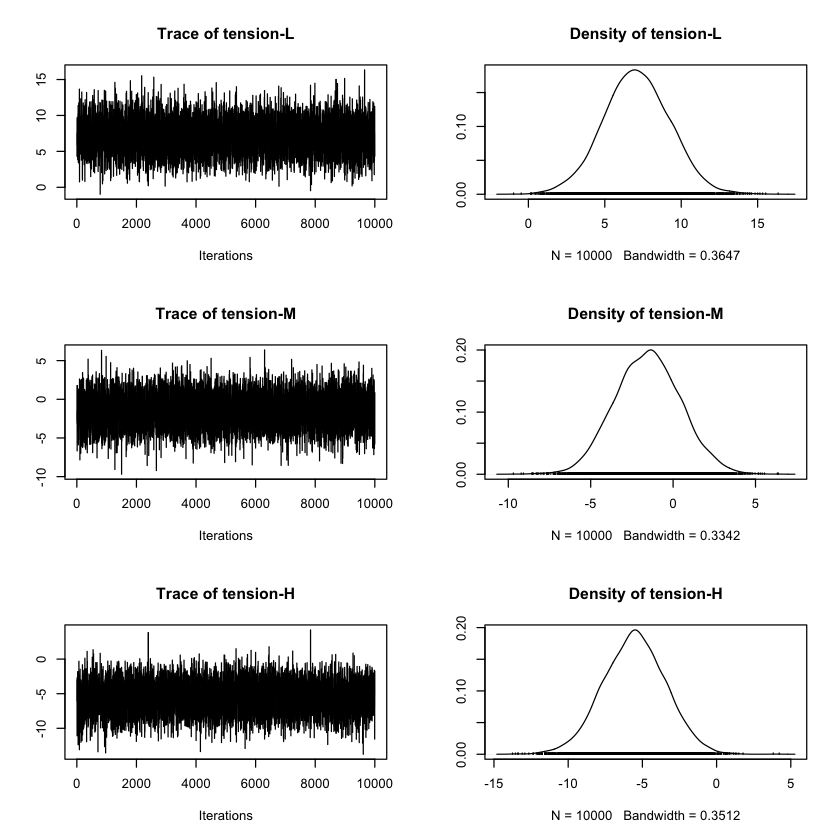

In [5]:
chains = posterior(InteractionModel, iterations=1e4)
plot(chains[,4:6])

## 9. Logistic Regression

### Related Terms

Function|Description
-|-
**Logit** | a **link function** (specifically, **log transformation** of **odds**)
**Logistic** | the inverse of the logit.
**Probit** | the inverse of CDF of the standard normal.
**${*}$Logistic Distribution**| a **distribution** whose CDF is logistic function

$$
\begin{aligned}
odds(\theta) &= \frac{\theta}{1-\theta} \\[10pt]
logit(\theta) &= log(\frac{\theta}{1-\theta}) \\[10pt]
logistic(x) &= \frac{1}{1 + e^{-x}} \ \ (\therefore \ \ logistic(logit(\theta)) = 1) \\[10pt]
probit(\theta) &= \Phi^{-1}(\theta) = \sqrt{2} erf^{-1} (2\theta-1) \\
\end{aligned}
$$

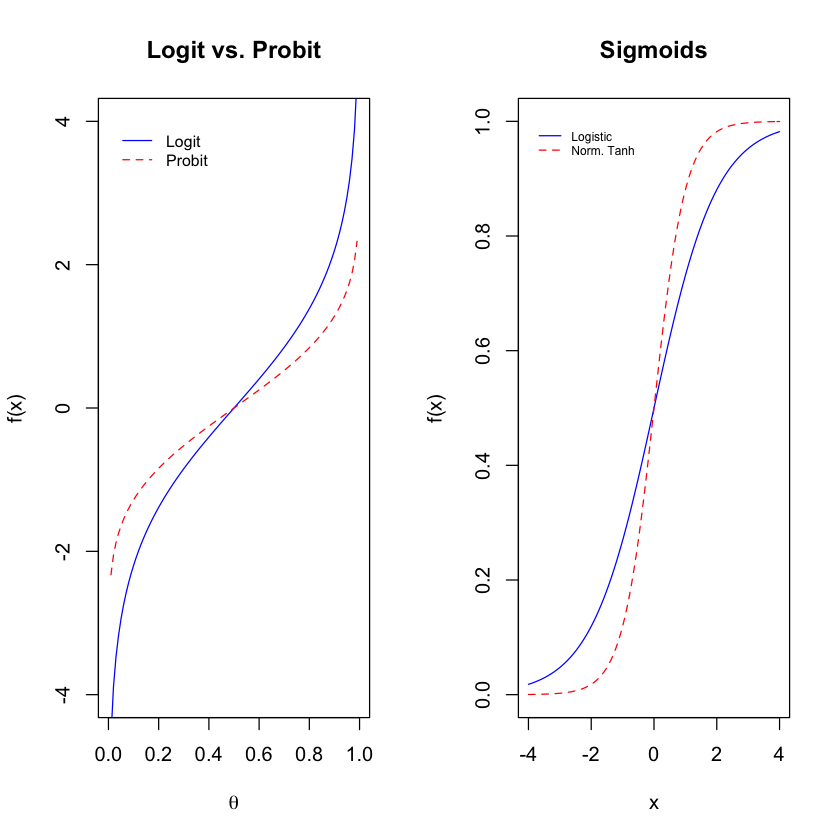

In [1]:
par(mfrow=c(1,2))

logit = function(x) log(x/(1-x))
plot(1, type="n", main="Logit vs. Probit", 
     xlab=expression(theta) , ylab="f(x)", xlim=c(0,1), ylim=c(-4,4))
curve(logit, add=T, col="blue", lty=1)
curve(qnorm, add=T, col="red", lty=2)
legend(0, 4, legend=c("Logit", "Probit"),
       col=c("blue", "red"), lty=1:2, cex=0.8, box.lty=0)

logistic = function(x) 1/(1+exp(-x))
tanh_trans= function(x) (tanh(x)+1)/2
plot(1, type="n", main="Sigmoids", 
     xlab="x" , ylab="f(x)", xlim=c(-4,4), ylim=c(0,1))

curve(logistic, add=T, col="blue", lty=1)
curve(tanh_trans, add=T, col="red", lty=2)
legend(-4, 1, legend=c("Logistic", "Norm. Tanh"),
       col=c("blue", "red"), lty=1:2, cex=0.6, box.lty=0)

### Generalized Linear Model

$$
\begin{aligned}
g[ \mathbb{E} (Y_i \mid x_i) ] &=  X \beta + \epsilon \\[10pt]
& \text{where } g \text{ denotes link function.}
\end{aligned}
$$

**Three Components**

+ **Random Component** : distribution of the **response var.** $Y$ (expressed in **residual noise**)

+ **Systematic Component** : the **linear** specification of the **explanatory vars** $(X_1, X_2, \ldots, X_k)$ in model

+ **Link Function** : **link** between random and systematic components. $\eta = g(\mathbb{E}(Y_i))$


**Assumptions**

+ Data $Y_i$ : **independently** distributed. (**no need to be normally** distributed, same for **errors**)

+ **Linear** relationship : between **transformed (by link)** dependent var. and independent var.

+ No need for **homogeneous variance**

### Logit link

Ensures that the **success probability** is between 0 and 1 without requiring any constraints on the $X$ or $\beta$

$$
\begin{aligned}
y_i \mid \phi _i &\overset{ind}{\sim} Bern(\phi_i) \ \ (i=1, \ldots, n) \\[10pt]
\mathbb{E}(y_i) &= \beta_0 + \beta_1 x_{1i} \\[10pt]
logit(\phi_i) &= log(\frac{\phi_i}{1-\phi_i}) \\[10pt]
&= \beta_0 + \beta_1 x_{1i}
\end{aligned}
$$

### Frequentist Modeling

In [29]:
dat = na.omit(urine)
X   = scale(dat[,-1], center=TRUE, scale=TRUE)

In [111]:
GLMmod = glm(dat$r ~ X[,"gravity"]+ X[,"ph"]+ X[,"osmo"]+ 
                     X[,"cond"]+ X[,"urea"]+ X[,"calc"], family = binomial(link = "logit"))
summary(GLMmod)


Call:
glm(formula = dat$r ~ X[, "gravity"] + X[, "ph"] + X[, "osmo"] + 
    X[, "cond"] + X[, "urea"] + X[, "calc"], family = binomial(link = "logit"))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6215  -0.5967  -0.2849   0.3176   2.7445  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)   
(Intercept)      0.1555     0.3712   0.419  0.67527   
X[, "gravity"]   2.6028     1.6242   1.603  0.10903   
X[, "ph"]       -0.3579     0.4114  -0.870  0.38429   
X[, "osmo"]      4.0259     4.2664   0.944  0.34536   
X[, "cond"]     -3.4643     2.0109  -1.723  0.08493 . 
X[, "urea"]     -4.1773     2.1033  -1.986  0.04703 * 
X[, "calc"]      2.5838     0.7984   3.236  0.00121 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 105.17  on 76  degrees of freedom
Residual deviance:  57.56  on 70  degrees of freedom
AIC: 71.56

Number of Fisher Scoring iteration

### Bayesian Modeling (STAN)

In [63]:
stanModel = "
  data {
    int<lower=0> n;
    int<lower=0> m;

    int y[n];
    real gravity[n];
    real ph[n];
    real osmo[n];
    real cond[n];
    real urea[n];
    real calc[n];

  }


  parameters {
    real inte;
    real b[m];
  }

  transformed parameters  {
      real<lower=0> odds[n];
      real<lower=0, upper=1> prob[n];

    for (i in 1:n) {
      odds[i] = exp(inte + b[1]*gravity[i] + b[2]*ph[i] + b[3]*osmo[i] + b[4]*cond[i] + b[5]*urea[i] + b[6]*calc[i]);
      prob[i] = odds[i] / (odds[i] + 1);
    }
  }

  model { 

    inte ~ normal(0.0, 5.0);

    for (j in 1:6){
      b[j] ~ double_exponential(0.0, sqrt(2.0));
    };

    for (i in 1:n){
      y[i] ~ bernoulli(prob[i]);
    }

  } "

dataStan = list(y=dat$r, gravity=X[,"gravity"], ph=X[,"ph"], osmo=X[,"osmo"], 
                cond=X[,"cond"], urea=X[,"urea"], calc=X[,"calc"], n=length(dat$r), m=6)

# modStan = stan(model_code=stanModel, data=dataStan, iter = 1e4, model_name="STAN_model")

Inference for Stan model: STAN_model.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

      mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
b[1]  2.55    0.01 1.02  0.73  1.83  2.49  3.22  4.72  9339    1
b[2] -0.20    0.00 0.35 -0.90 -0.43 -0.19  0.03  0.45 16370    1
b[3] -0.26    0.01 1.41 -3.15 -1.09 -0.22  0.51  2.68  9155    1
b[4] -1.14    0.01 0.75 -2.73 -1.61 -1.10 -0.64  0.24  9388    1
b[5] -1.31    0.01 0.92 -3.28 -1.89 -1.25 -0.65  0.28  9483    1
b[6]  1.98    0.01 0.58  0.95  1.57  1.94  2.35  3.21 12683    1

Samples were drawn using NUTS(diag_e) at Tue Feb 20 03:27:56 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


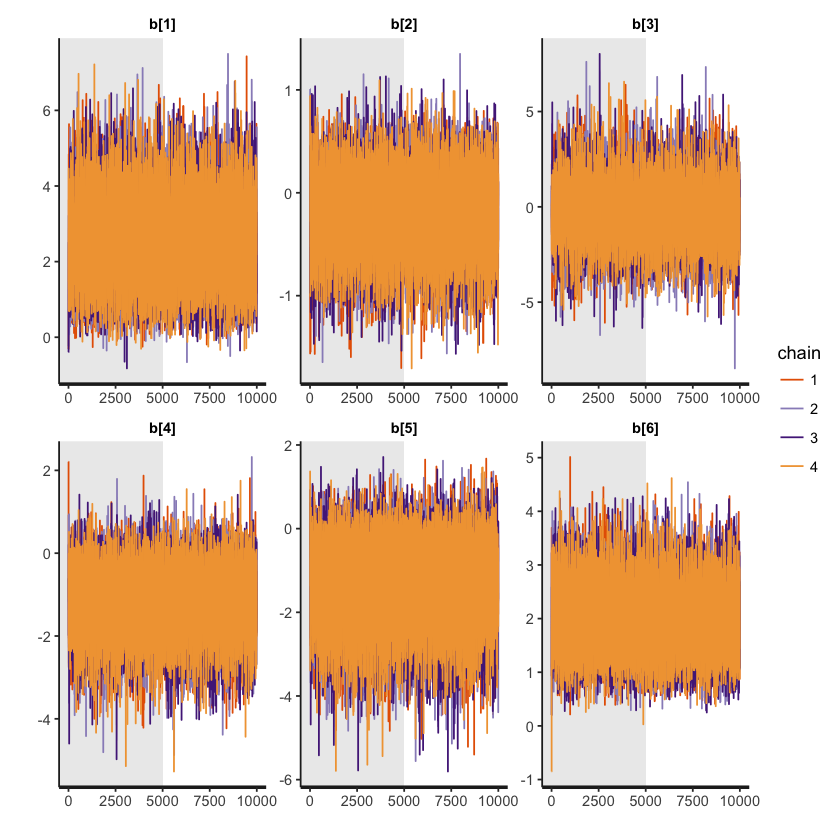

In [62]:
print(modStan, pars = c("b"))
traceplot(modStan, pars = c("b"), inc_warmup = TRUE)

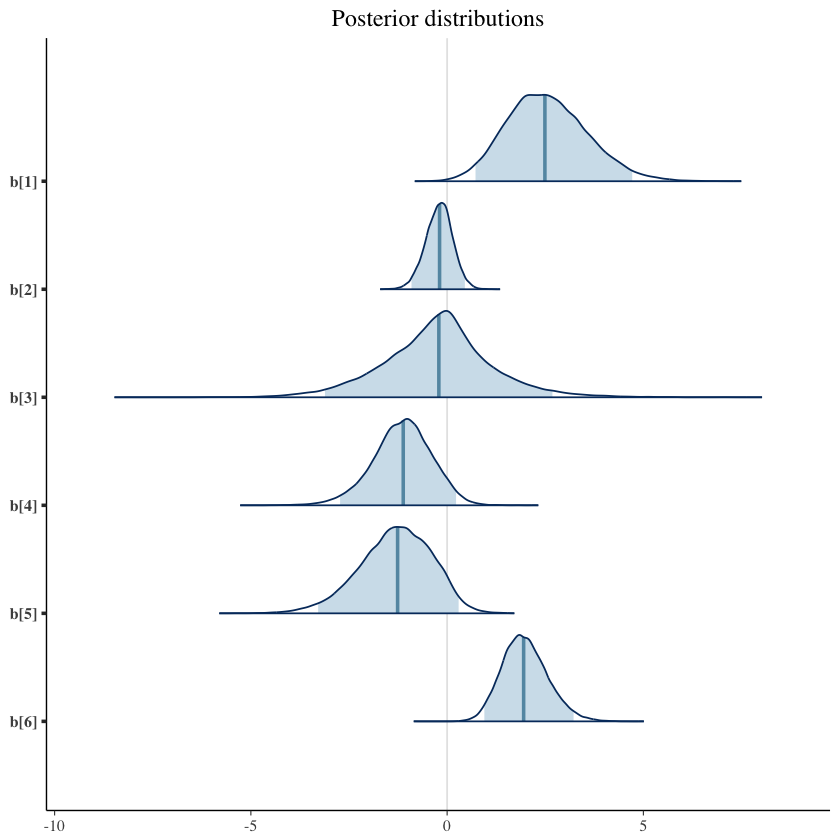

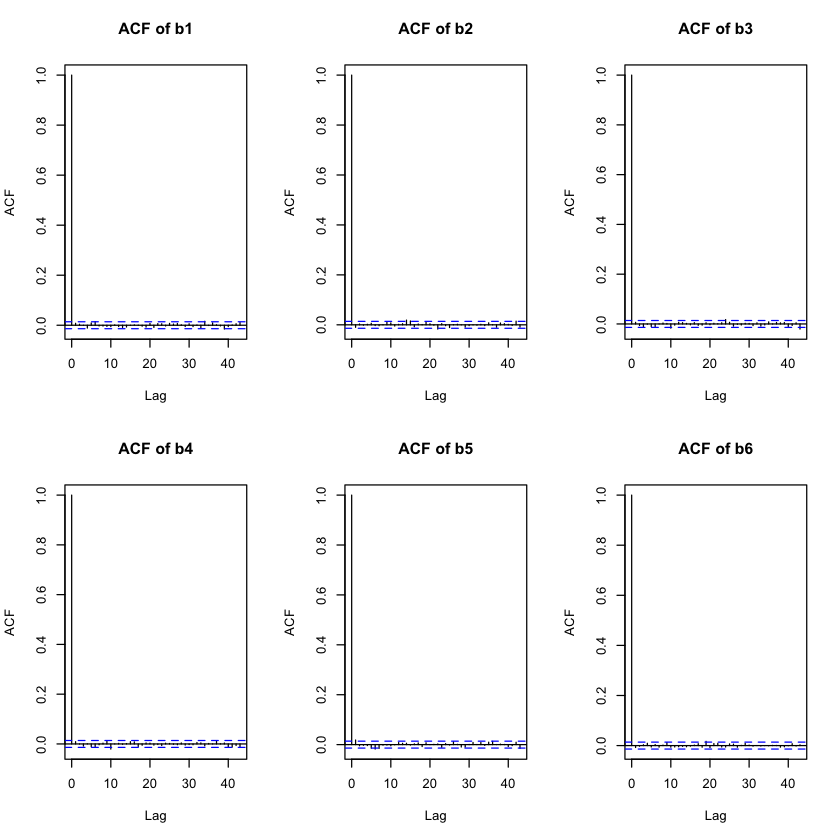

In [84]:
Sam = extract(modStan, "b", permuted =F,inc_warmup =T)
mcmc_areas(Sam, prob =0.95) + 
    ggtitle("Posterior distributions") +
    theme(plot.title = element_text(hjust = 0.5))

Sam = extract(modStan)
par(mfrow=c(2,3))
for (i in 1:6) acf(Sam$b[,i], main=paste0("ACF of b", i))

### Prediction from a logisic regression model

**Posterior predictive check**

In [97]:
Sam     = extract(modStan, c("b", "inte"))
pm_coef = apply(cbind(Sam$inte, Sam$b), 2, mean)

In [99]:
pm_Xb   = pm_coef[1] + X %*% pm_coef[2:7]
phat    = 1.0 / (1.0 + exp(-pm_Xb))
head(phat)

2,0.42191281
3,0.10087287
4,0.14306380
5,0.07845330
6,0.44065395
7,0.08528207


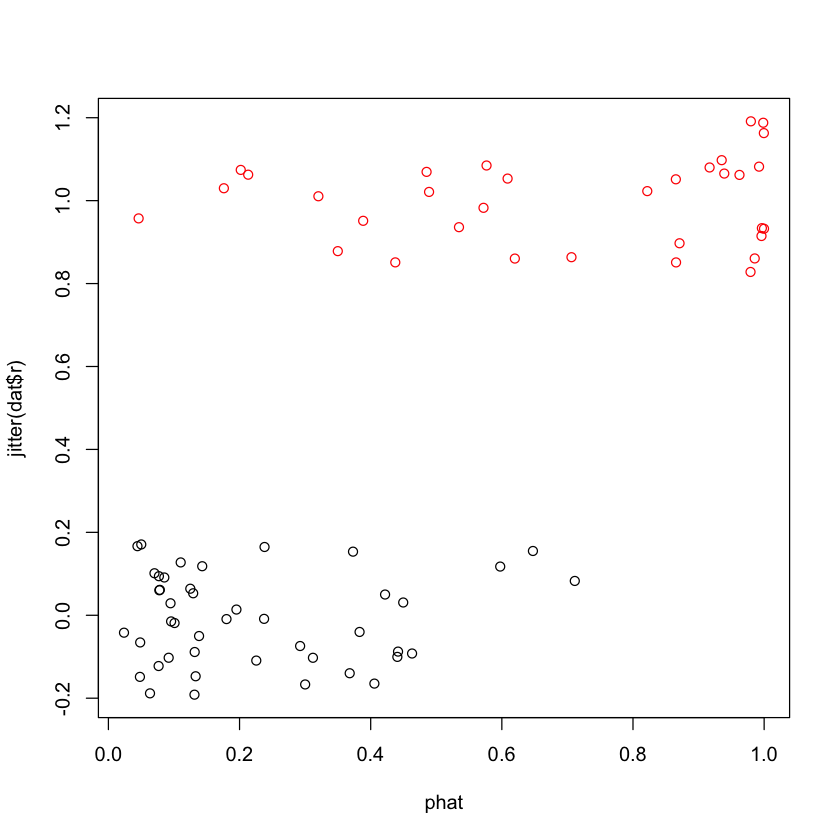

In [103]:
plot(phat, jitter(dat$r), col=dat$r+1)

In [112]:
phat_binary = ifelse(phat > 0.5, 1, 0) 
confusionMatrix(phat_binary, dat$r, positive="1")

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 41 10
         1  3 23
                                          
               Accuracy : 0.8312          
                 95% CI : (0.7286, 0.9069)
    No Information Rate : 0.5714          
    P-Value [Acc > NIR] : 1.138e-06       
                                          
                  Kappa : 0.6459          
 Mcnemar's Test P-Value : 0.09609         
                                          
            Sensitivity : 0.6970          
            Specificity : 0.9318          
         Pos Pred Value : 0.8846          
         Neg Pred Value : 0.8039          
             Prevalence : 0.4286          
         Detection Rate : 0.2987          
   Detection Prevalence : 0.3377          
      Balanced Accuracy : 0.8144          
                                          
       'Positive' Class : 1               
                                          

In [115]:
glm_pred   = predict(GLMmod, data.frame(X), type = "response") 
glm_binary = ifelse(glm_pred > 0.5, 1, 0) 
confusionMatrix(glm_binary, dat$r, positive="1")

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 40  8
         1  4 25
                                          
               Accuracy : 0.8442          
                 95% CI : (0.7436, 0.9168)
    No Information Rate : 0.5714          
    P-Value [Acc > NIR] : 2.942e-07       
                                          
                  Kappa : 0.6769          
 Mcnemar's Test P-Value : 0.3865          
                                          
            Sensitivity : 0.7576          
            Specificity : 0.9091          
         Pos Pred Value : 0.8621          
         Neg Pred Value : 0.8333          
             Prevalence : 0.4286          
         Detection Rate : 0.3247          
   Detection Prevalence : 0.3766          
      Balanced Accuracy : 0.8333          
                                          
       'Positive' Class : 1               
                                          

[[1]]
[1] 0.8911846

[[1]]
[1] 0.8987603

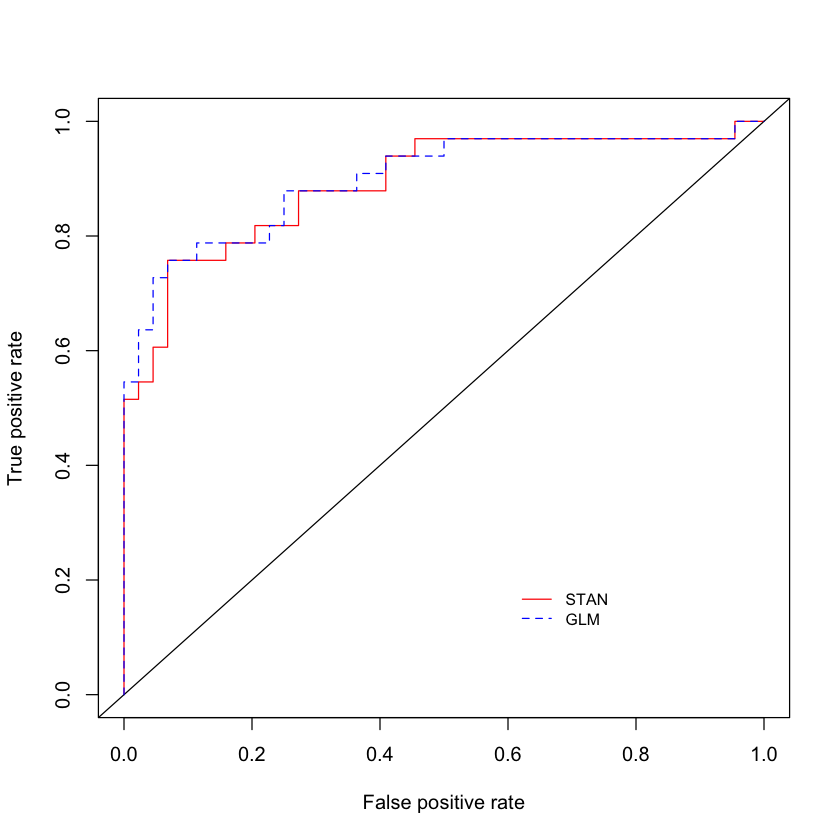

In [120]:
library(ROCR)

stanPred = prediction(phat, dat$r)
glmPred  = prediction(glm_pred, dat$r)

stan_perf = performance(stanPred, measure="tpr", x.measure="fpr")
glm_perf  = performance(glmPred, measure="tpr", x.measure="fpr")

stan_auc = performance(stanPred, measure="auc")
glm_auc  = performance(glmPred, measure="auc")

par(mfrow=c(1,1))
plot(stan_perf,col="red"); abline(a=0,b=1)
plot(glm_perf, col="blue",add=T, lty=2)
legend(.6, .2, legend=c("STAN", "GLM"), col=c("red", "blue"), lty=1:2, cex=.8, box.lty=0)

stan_auc@y.values
glm_auc@y.values